In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import generic_filter, gaussian_filter, median_filter
import marker_detection

%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (12, 7)

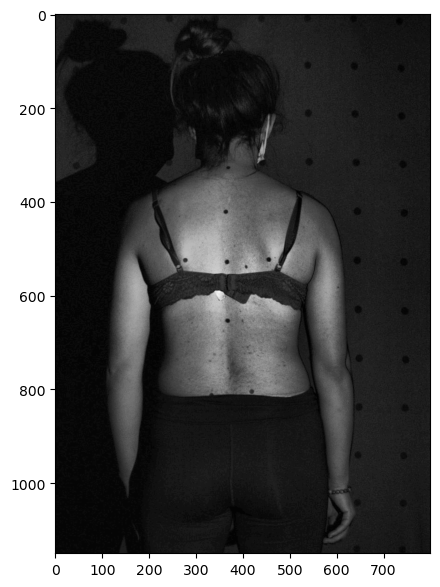

In [101]:
image = cv2.imread(r'C:\Users\LEA\Desktop\Poly\H2023\Projet3\Data\Ete_2022\Participant05\autocorrection\Prise01\intensity\auto_01_010457_I_0.jpg')
crop = (350, 1500, 200, 1000)

image = marker_detection.preprocess(image, crop)[0]

plt.imshow(image, cmap='gray')
plt.show()

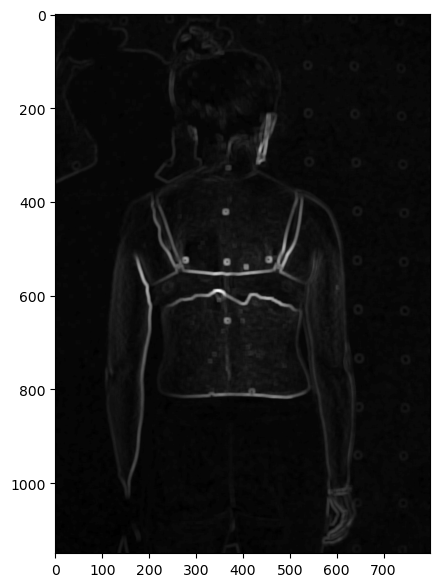

In [102]:
w = image.shape[0]
h = image.shape[1]
im_std = generic_filter(image, np.std, 9, mode='nearest').reshape(w,h)
plt.imshow(im_std, cmap='gray')
plt.show()

4.0141989130434785 80
81
522 433


C:\Users\LEA\AppData\Local\Temp\ipykernel_14116\3271735743.py:17: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax3.imshow(image2, cmap='gray')


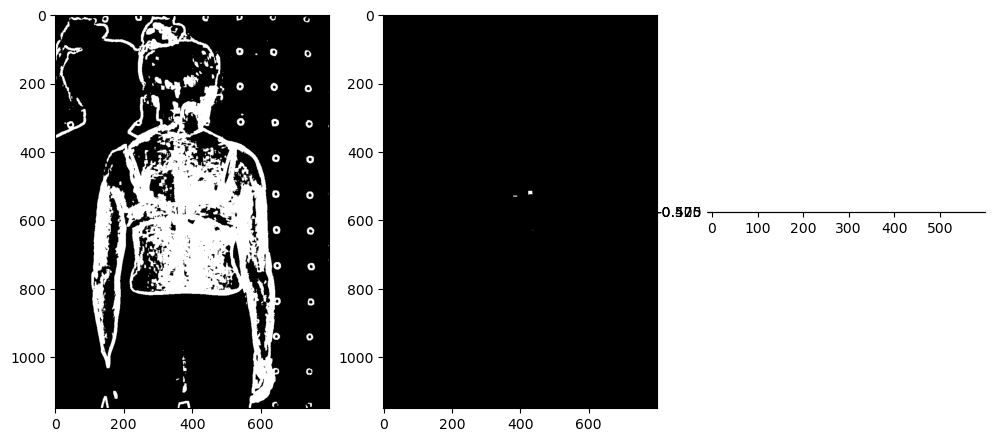

In [103]:
mean = im_std.mean()
max = im_std.max()
print(mean, max)
im_crop = np.where(im_std > mean, 1, 0)
im_crop_g = gaussian_filter(im_crop, 7)
crop = np.where(im_crop_g == 1)
mid = int(len(crop[0])/2)
print(mid)
crop_y = crop[0][mid]
crop_x = crop[1][mid]
print(crop_y, crop_x)

image2 = image[crop_y-800:crop_y+80, crop_x-350:crop_x+250]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im_crop, cmap='gray')
ax2.imshow(im_crop_g, cmap='gray')
ax3.imshow(image2, cmap='gray')
plt.show()